In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

import tensorflow
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

In [28]:
train = pd.read_csv(r"C:\Users\tasab\Downloads\digit-recognizer\train.csv")
test = pd.read_csv(r"C:\Users\tasab\Downloads\digit-recognizer\test.csv")


label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

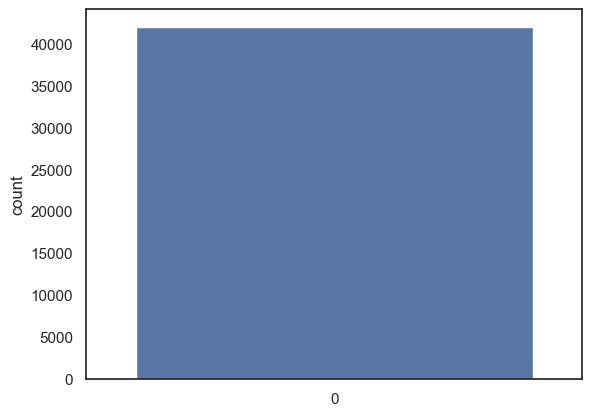

In [29]:
y_train = train['label']
x_train = train.drop(labels= ['label'], axis = 1)
del train
g = sns.countplot(y_train)
y_train.value_counts()

In [30]:
#normalize the data
x_train = x_train / 255.0
test = test / 255.0

In [31]:
#reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
x_train = x_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [32]:
y_train = to_categorical(y_train, num_classes= 10)

In [33]:
random_seed = 2
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size= 0.1, random_state=random_seed)

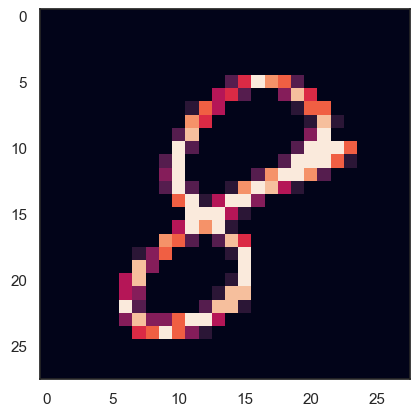

In [34]:
#some examples
g = plt.imshow(x_train[0][:,:,0])


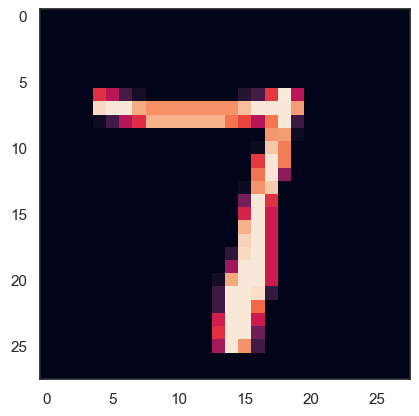

In [35]:
g = plt.imshow(x_train[1][:,:,0])


In [36]:
#build the CNN model
model = Sequential()

model.add(Conv2D(filters= 32, kernel_size= (5,5), padding= 'Same',
                 activation= 'relu', input_shape = (28,28,1)))
model.add(Conv2D(filters= 32, kernel_size= (5,5), padding= 'Same',
                 activation= 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters= 64, kernel_size= (3,3), padding= 'Same',
                 activation= 'relu'))
model.add(Conv2D(filters= 64, kernel_size= (3,3), padding= 'Same',
                 activation= 'relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))


In [37]:
#define the optimizer
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08)

In [38]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [39]:
#set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
#set an early stop to avoid overfitting
early_stop = tensorflow.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 1, min_delta = 0.0001,restore_best_weights = True,verbose = 1)

In [40]:
epochs = 5
batch_size = 86

In [41]:
 #apply data augmentaion to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [42]:
#fit the model
history = model.fit(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_val,y_val),
                              verbose = 2, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction, early_stop])

Epoch 1/5
439/439 - 176s - loss: 0.4076 - accuracy: 0.8685 - val_loss: 0.0651 - val_accuracy: 0.9812 - lr: 0.0010 - 176s/epoch - 402ms/step
Epoch 2/5
439/439 - 124s - loss: 0.1333 - accuracy: 0.9600 - val_loss: 0.0571 - val_accuracy: 0.9821 - lr: 0.0010 - 124s/epoch - 284ms/step
Epoch 3/5
439/439 - 101s - loss: 0.0945 - accuracy: 0.9717 - val_loss: 0.0400 - val_accuracy: 0.9874 - lr: 0.0010 - 101s/epoch - 230ms/step
Epoch 4/5
439/439 - 116s - loss: 0.0777 - accuracy: 0.9763 - val_loss: 0.0277 - val_accuracy: 0.9912 - lr: 0.0010 - 116s/epoch - 264ms/step
Epoch 5/5
Restoring model weights from the end of the best epoch: 4.
439/439 - 137s - loss: 0.0688 - accuracy: 0.9801 - val_loss: 0.0292 - val_accuracy: 0.9921 - lr: 0.0010 - 137s/epoch - 313ms/step
Epoch 5: early stopping


In [43]:
#predict results
results = model.predict(test)

# select the index with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission

875/875 [==============================] - 20s 23ms/step


,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
